In [15]:
import akshare as ak
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scikeras.wrappers import KerasRegressor
from keras.models import load_model
from datetime import datetime, timedelta

In [16]:
# 用户输入股票编号
symbol=input("请输入股票代码（例如600916）：")
# 设置起始和结束日期
start_date='20230101'
end_date=datetime.now().strftime('%Y%m%d')
# 使用akshare获取股票日线数据
s=ak.stock_zh_a_hist(symbol=symbol, adjust="qfq", period="daily", start_date=start_date, end_date=end_date)
# 检查是否获取到数据
if not s.empty:
    # 选择你需要的列
    selected_columns=['日期', '开盘', '收盘', '最高', '最低','成交量']
    df_final=s[selected_columns]
    # 获取上海证券交易所和深圳证券交易所股票名称
    sh_info=ak.stock_info_sh_name_code()
    sz_info=ak.stock_info_sz_name_code()
    # 修改列名
    sh_info.rename(columns={'证券代码':'公司代码'},inplace=True)
    sz_info.rename(columns={'A股代码':'公司代码','A股简称':'公司全称'},inplace=True)
    all_info=pd.concat([sh_info,sz_info],ignore_index=True)
    stock_name_all=all_info[all_info['公司代码']==symbol] 
    if not stock_name_all.empty:
        stock_name=stock_name_all['公司全称'].values[0]
        # 动态生成 CSV 文件名
        csv_name=f"{stock_name}股票数据.csv"
        # 将数据保存到CSV文件
        df_final.to_csv(csv_name,index=False,encoding='utf_8_sig')
        print(f'保存成功，文件名为 {csv_name}')
    else:
        print("未找到股票名称，请检查股票代码是否正确")
else:
    print("在指定日期内未找到任何数据")

请输入股票代码（例如600916）： 600916


保存成功，文件名为 中国黄金集团黄金珠宝股份有限公司股票数据.csv


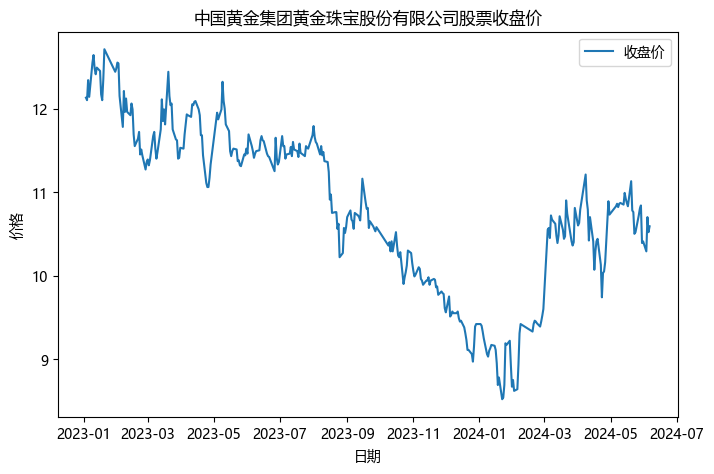

In [17]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]#使用中文字体
# 读取数据
df=pd.read_csv(csv_name,encoding='utf_8_sig',parse_dates=['日期'],index_col='日期')
# 可视化股票收盘价
plt.figure(figsize=(8, 5))
plt.plot(df['收盘'], label='收盘价')
plt.title(f'{stock_name}股票收盘价')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.show()

In [18]:
df=pd.read_csv(csv_name,encoding='utf_8_sig')
# 将日期列转换为日期时间格式，并设置为索引
df['日期']=pd.to_datetime(df['日期'])
df.set_index('日期',inplace=True)
# 选择收盘价特征
data=df[['收盘']]
# 初始化MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
# 标准化数据
sc_data=scaler.fit_transform(data)
# 创建时间序列数据
def create_dataset(dataset,time_step=1):
    x_data,y_data=[],[]   # 初始化特征和标签列表
# 遍历数据集，创建样本和对应的标签
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i + time_step),0]   #取连续 time_step 个时间点的数据作为特征
        x_data.append(a)
        y_data.append(dataset[i + time_step, 0])   #第 time_step+1 个时间点的数据作为标签
    return np.array(x_data), np.array(y_data)
# 设定时间步长
time_step=20
x, y=create_dataset(sc_data, time_step)
# 划分训练集和测试集
train_size=int(len(x) * 0.7)#将数据集的70%数据作为训练集，剩下的30%为测试集
test_size=len(x)-train_size
x_train, x_test=x[0:train_size],x[train_size:len(x)]
y_train, y_test=y[0:train_size],y[train_size:len(y)]
# 重塑数据以适应LSTM输入格式 [样本数, 时间步, 特征数]
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [5]:
# 使用 Keras 的 Sequential API 构建一个 LSTM 模型
model=Sequential()
model.add(LSTM(50,return_sequences=True))# 添加第二个 LSTM 层，50 个 LSTM 单元
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
# 添加输出层，1 个神经元，用于预测下一个时间点的收盘价
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=1, epochs=20, validation_split=0.1, verbose=0)

In [6]:
# 保存模型
model.save('my_model.keras')
print("模型已保存")

模型已保存


In [7]:
# 加载使用Keras原生格式保存的模型
my_model=tf.keras.models.load_model('my_model.keras')
print("模型已加载")
# 预测
test_pre=my_model.predict(x_test)
train_pre=my_model.predict(x_train)

模型已加载
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [8]:
#反归一化数据
train_pre1=np.repeat(train_pre,30, axis=-1) 
train_pre2=scaler.inverse_transform(np.reshape(train_pre1,(len(train_pre),30)))[:,0]
train_actual1=np.repeat(y_train,30, axis=-1)
train_actual2=scaler.inverse_transform(np.reshape(train_actual1,(len(y_train),30)))[:,0]
pre=np.repeat(test_pre,30, axis=-1) 
x_pre=scaler.inverse_transform(np.reshape(pre,(len(test_pre),30)))[:,0]
x_actual1=np.repeat(y_test,30, axis=-1)
x_actual2=scaler.inverse_transform(np.reshape(x_actual1,(len(y_test),30)))[:,0]
print("测试集预测值",x_pre)
print("\n测试集实际值",x_actual2)
print("训练集预测值 ",train_pre2)
print("\n训练集实际值" ,train_actual2)

测试集预测值 [ 9.230507   9.105137   9.015663   9.003      9.0248     9.062342
  9.082615   9.069214   8.987709   8.824635   8.752632   8.628163
  8.553005   8.573949   8.802218   8.974812   9.079774   8.997719
  8.808909   8.710522   8.619842   8.576657   8.672735   8.915999
  9.138175   9.216168   9.267483   9.304144   9.314379   9.306197
  9.281572   9.29619    9.34611    9.4193535  9.578522  10.043853
 10.335603  10.365012  10.485816  10.510597  10.476548  10.375547
 10.281058  10.303796  10.475144  10.483449  10.411046  10.393959
 10.654851  10.703251  10.54757   10.414682  10.335993  10.338739
 10.598266  10.614429  10.608846  10.695151  10.999761  10.935479
 10.79317   10.500973  10.54147   10.430843  10.188507  10.204003
 10.319045  10.407494  10.265952   9.966842   9.965897  10.015639
 10.108836  10.573791  10.726106  10.792969  10.805312  10.761341
 10.751302  10.753811  10.744816  10.832165  10.835694  10.801358
 10.76406   10.945043  10.817818  10.730519  10.547159  10.487022
 10

In [9]:
# 评估模型性能
# 计算均方误差（MSE）
mse=mean_squared_error(x_actual2,x_pre)
#计算确定系数（R^2）
r=r2_score(x_actual2,x_pre)
# 计算平均绝对误差（MAE）
mae=mean_absolute_error(x_actual2,x_pre)
print("该模型的平均绝对误差为:", mae)
print("该模型的确定系数为:",r)
print("该模型的均方误差为:",mse)

该模型的平均绝对误差为: 0.2006662392370481
该模型的确定系数为: 0.8789647551556992
该模型的均方误差为: 0.07192163034027814


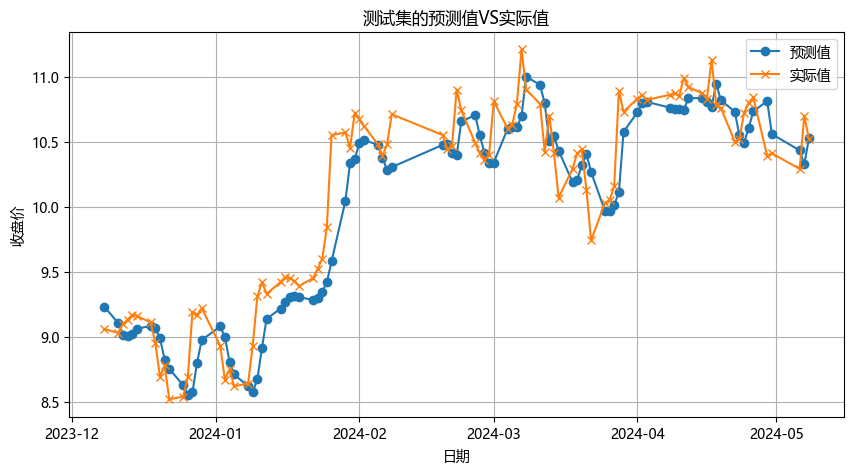

In [10]:
# 绘制测试集预测值与实际值
plt.figure(figsize=(10, 5))
test_start_index=len(train_pre2)  # 训练集结束的索引位置，测试集开始于此
test_dates=data.index[test_start_index:test_start_index + len(x_pre)]  # 获取测试集的日期索引
plt.plot(test_dates,x_pre,label='预测值', marker='o')  # 使用测试集日期作为x轴
plt.plot(test_dates,x_actual2,label='实际值', marker='x')  # 同样使用测试集日期
plt.title('测试集的预测值VS实际值')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.legend()
plt.grid(True)
plt.show()

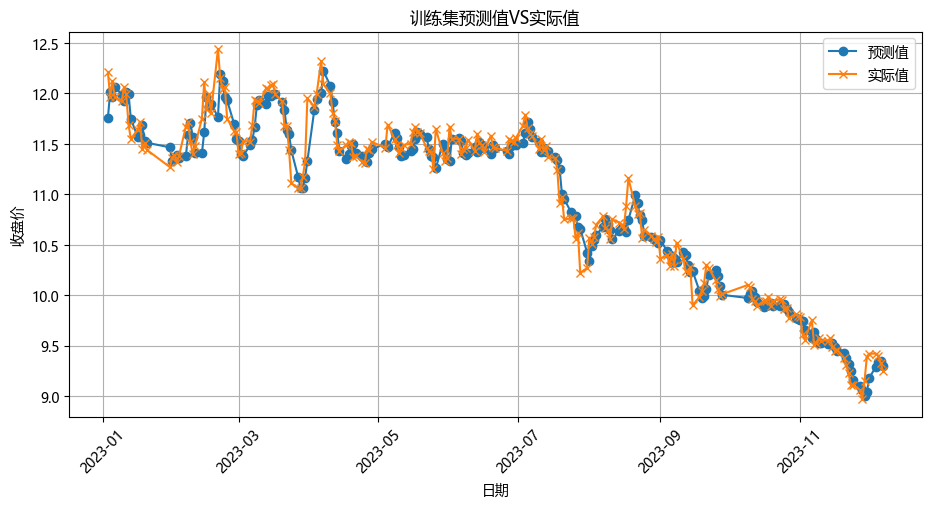

In [11]:
# 绘制训练集预测值与实际值
plt.figure(figsize=(11, 5))
train_dates=data.index[ :test_start_index]
plt.plot(train_dates, train_pre2, label='预测值', marker='o')  # 使用测试集日期作为x轴
plt.plot(train_dates, train_actual2, label='实际值', marker='x') 
plt.title('训练集预测值VS实际值')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.xticks(rotation=45)  # 旋转x轴标签文本，避免重叠
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 利用训练好的模型预测未来七天
f_days=7
last_day=sc_data[-time_step:]
f_pre=[]
for _ in range(f_days):
    x=last_day.reshape(1,time_step,1)
    pred_p=my_model.predict(x,verbose=0)
    f_pre.append(pred_p[0, 0])
    last_day=np.append(last_day[1:],pred_p)
f_pre=np.array(f_pre).reshape(-1, 1)
f_pre=scaler.inverse_transform(f_pre)
f_pre=[f'{price:.2f}' for price in f_pre.flatten()]
print('未来七天的预测价格:',', '.join(f_pre))

未来七天的预测价格: 10.58, 10.58, 10.57, 10.55, 10.53, 10.51, 10.48


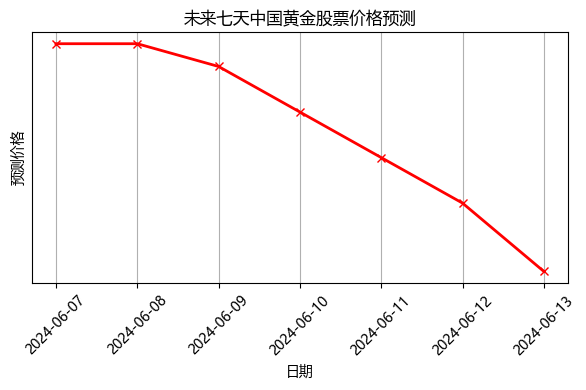

In [13]:
# 假设当前代码段是紧接着您提供的预测代码部分
# 获取当前日期作为预测的起始日期
now_date=datetime.now().date()
f_dates=[now_date + timedelta(days=i) for i in range(1,f_days + 1)]
# 纵坐标起点从10开始，间隔为0.1
yticks=np.arange(10.9,int(max(map(float,f_pre))) + 0.1, 0.1)
# 可视化预测数据
plt.figure(figsize=(6,4))
plt.plot(f_dates,[float(price) for price in f_pre],marker='x',linestyle='-',color='red',linewidth=2)
# 设置横纵坐标标签和刻度
plt.xlabel('日期')
plt.ylabel('预测价格')
plt.xticks(f_dates,rotation=45)  # 旋转x轴日期标签
plt.yticks(yticks)
# 添加标题
plt.title('未来七天中国黄金股票价格预测')
# 显示网格
plt.grid(True)
# 自动调整子图参数, 使之填充整个图像区域
plt.tight_layout()
# 显示图表
plt.show()

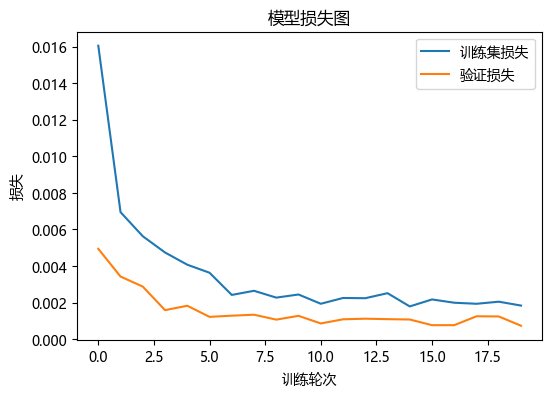

In [14]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='训练集损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型损失图')
plt.xlabel('训练轮次')
plt.ylabel('损失')
plt.legend()
plt.show()